#Function Definitions

In [ ]:
def download_and_extract_zip(file_id, target_folder_name):
    # Mount Google Drive
    drive.mount('/content/drive')

    # Define the URL for the file
    url = f'https://drive.google.com/uc?id={file_id}'

    # Define the path for the downloaded ZIP file
    zip_file_path = f'/content/{target_folder_name}.zip'

    # Download the ZIP file
    gdown.download(url, zip_file_path, quiet=False)

    # Define temporary extraction directory
    temp_extract_dir = '/content/temp_extract/'

    # Define the target directory
    extract_dir = f'/content/{target_folder_name}/'

    # Create the target directory if it doesn't exist
    os.makedirs(extract_dir, exist_ok=True)

    # Create the temporary extraction directory
    os.makedirs(temp_extract_dir, exist_ok=True)

    # Unzip the file to the temporary directory
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(temp_extract_dir)

    # Move the contents of the temporary directory to the target directory
    for item in os.listdir(temp_extract_dir):
        s = os.path.join(temp_extract_dir, item)
        d = os.path.join(extract_dir, item)
        if os.path.isdir(s):
            shutil.move(s, d)
        else:
            shutil.move(s, d)

    # Remove the temporary directory
    shutil.rmtree(temp_extract_dir)

    # Optionally, remove the ZIP file after extraction
    os.remove(zip_file_path)

    # Return the path to the extracted directory
    return extract_dir

In [ ]:
def delete_folder(folder_path):
    # Check if the folder exists
    if os.path.exists(folder_path):
        # Delete the folder and its contents
        shutil.rmtree(folder_path)

In [ ]:
def extract_number(filename):
    # Extract numerical part from filename
    return int(filename.stem.split('_')[-1])

In [ ]:
def preprocess(image, label, num_classes):
  # One-hot encode the labels
  label = tf.one_hot(label, depth=num_classes)
  return image, label

#Imports

In [ ]:
import os
import pathlib
import shutil
import zipfile
import numpy as np
import PIL
import gdown

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling

from google.colab import drive

#Download and Extract Images

In [ ]:
file_id = '1q5NS8Hv7GMtawxxOB0jGuwooSG-yrdcI'
target_folder_name = 'Automating_Port_Operations_dataset'

In [ ]:
download_dir = download_and_extract_zip(file_id, target_folder_name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading...
From (original): https://drive.google.com/uc?id=1q5NS8Hv7GMtawxxOB0jGuwooSG-yrdcI
From (redirected): https://drive.google.com/uc?id=1q5NS8Hv7GMtawxxOB0jGuwooSG-yrdcI&confirm=t&uuid=c11be81a-bfd6-4db7-809c-6e81c2a8902d
To: /content/Automating_Port_Operations_dataset.zip
100%|██████████| 150M/150M [00:01<00:00, 110MB/s]


In [ ]:
data_dir = pathlib.Path(download_dir + '//' + target_folder_name + '//')
data_dir

PosixPath('/content/Automating_Port_Operations_dataset/Automating_Port_Operations_dataset')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1162


# 1. Build a CNN network to classify the boat

**1.1.	Split the dataset into train and test in the ratio 80:20, with shuffle and random state=43**

**1.2 Use tf.keras.preprocessing.image_dataset_from_directory to load the train and test datasets. This function also supports data normalization.**

**1.3 Load train, validation and test dataset in batches of 32 using the function initialized in the above step.**

In [ ]:
batch_size = 32 # for training we will pass images in batches of 32 to the model
img_height = 180 # standardizing the height and width of the images
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=43,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  labels='inferred')

Found 1162 files belonging to 9 classes.
Using 930 files for training.


In [ ]:
# create a folder structure with class names for validation images
temp_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.5,
  subset="validation",
  seed=43,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  labels='inferred')

Found 1162 files belonging to 9 classes.
Using 581 files for validation.


In [ ]:
val_ds = temp_ds.take(len(temp_ds) // 2)  # Take the first half for validation
test_ds = temp_ds.skip(len(temp_ds) // 2)  # Skip the first half for testing

In [ ]:
print("Training set size:", len(train_ds))
print("Validation set size:", len(val_ds))
print("Test set size:", len(test_ds))

Training set size: 30
Validation set size: 9
Test set size: 10


In [ ]:
# get the class label names before applying map for image rescale
class_names = train_ds.class_names
print(class_names)

['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat']


In [ ]:
class_indices = {class_name: index for index, class_name in enumerate(class_names)}
print(class_indices)

{'buoy': 0, 'cruise_ship': 1, 'ferry_boat': 2, 'freight_boat': 3, 'gondola': 4, 'inflatable_boat': 5, 'kayak': 6, 'paper_boat': 7, 'sailboat': 8}


In [ ]:
for images, labels in train_ds.take(1):  # Take one batch
    print(images.shape)

(32, 180, 180, 3)


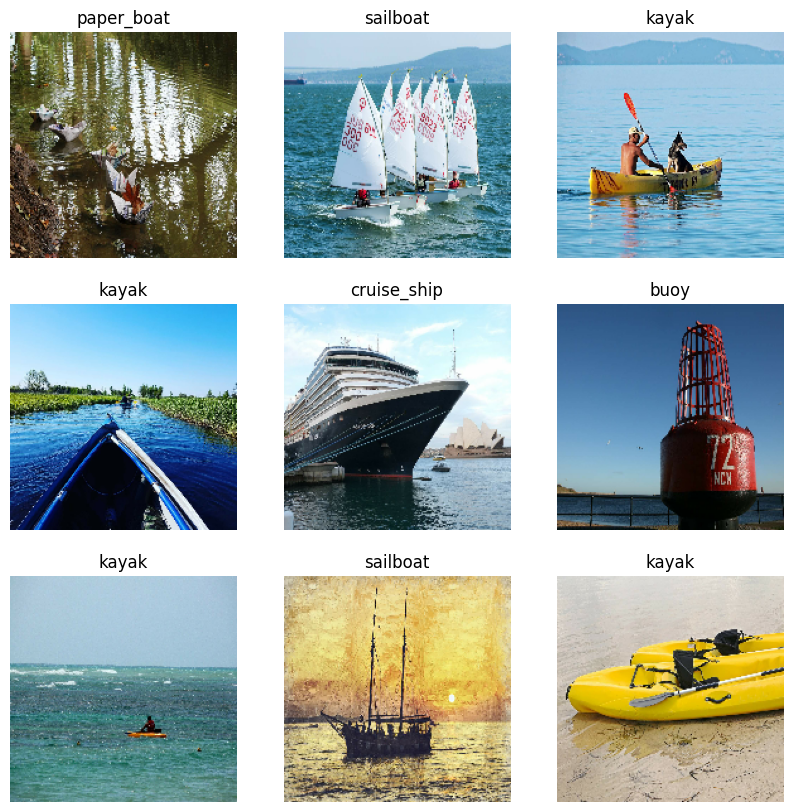

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):

  # plot 9 images from the first batch
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**1.4 Build a CNN network using Keras with the following layers**


* Cov2D with 32 filters, kernel size 3,3, and activation relu, followed by MaxPool2D
* Cov2D with 32 filters, kernel size 3,3, and activation relu, followed by MaxPool2D
* GLobalAveragePooling2D layer
* Dense layer with 128 neurons and activation relu
* Dense layer with 128 neurons and activation relu
* Dense layer with 9 neurons and activation softmax.



In [ ]:
AUTOTUNE = tf.data.AUTOTUNE # optimize for performance

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = len(class_names)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

# Apply Rescaling to normalize pixel values
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda image, label: preprocess(image, label, num_classes))

In [ ]:
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda image, label: preprocess(image, label, num_classes))

In [ ]:
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda image, label: preprocess(image, label, num_classes))

In [ ]:
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) # checking the min and max pixel values in the batch

0.0 1.0


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), activation='relu'),
  layers.MaxPooling2D(),
  layers.GlobalAveragePooling2D(),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,041 (125.16 KB)

 Trainable params: 32,041 (125.16 KB)

 Non-trainable params: 0 (0.00 B)

**1.5.	Compile the model with Adam optimizer, categorical_crossentropy loss, and with metrics accuracy, precision, and recall.**

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

**1.6.	Train the model for 20 epochs and plot training loss and accuracy against epochs.**

In [ ]:
epochs=20 # we will train model for 20 epochs

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.2470 - loss: 2.0886 - precision: 0.3394 - recall: 0.0083 - val_accuracy: 0.3576 - val_loss: 1.8106 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3531 - loss: 1.8064 - precision: 0.5394 - recall: 0.0129 - val_accuracy: 0.3576 - val_loss: 1.8103 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3388 - loss: 1.8231 - precision: 0.8065 - recall: 0.0018 - val_accuracy: 0.3576 - val_loss: 1.7703 - val_precision: 0.7727 - val_recall: 0.0590
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3561 - loss: 1.7677 - precision: 0.6593 - recall: 0.0384 - val_accuracy: 0.3576 - val_loss: 1.7710 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3474 - loss: 1.7874 - precision: 0.4632 - recall: 0.0138 - val_accuracy: 

**1.7.	Evaluate the model on test images and print the test loss and accuracy.**

In [ ]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_ds)

print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)
print('Test precision:', test_precision)
print('Test recall:', test_recall)

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.4111 - loss: 1.6095 - precision: 0.7086 - recall: 0.0975
Test loss: 1.583411455154419
Test accuracy: 0.4197952151298523
Test precision: 0.7317073345184326
Test recall: 0.10238907486200333


**1.8.	Plot heatmap of the confusion matrix and print classification report.**

In [ ]:
# Get predictions
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels, axis=1))

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step


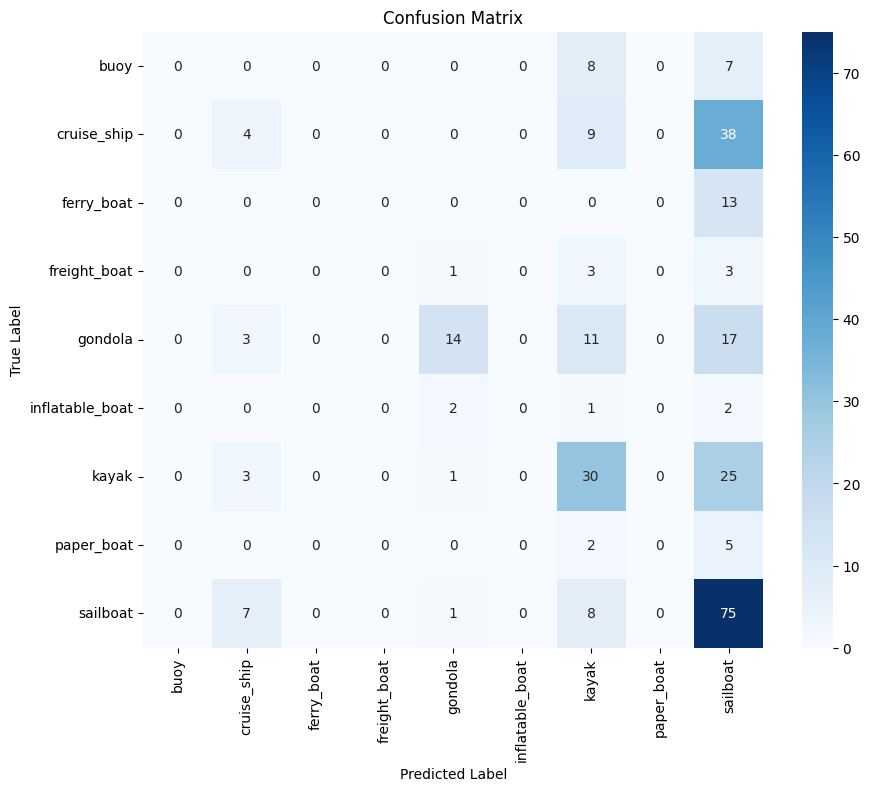

                 precision    recall  f1-score   support

           buoy       0.00      0.00      0.00        15
    cruise_ship       0.24      0.08      0.12        51
     ferry_boat       0.00      0.00      0.00        13
   freight_boat       0.00      0.00      0.00         7
        gondola       0.74      0.31      0.44        45
inflatable_boat       0.00      0.00      0.00         5
          kayak       0.42      0.51      0.46        59
     paper_boat       0.00      0.00      0.00         7
       sailboat       0.41      0.82      0.54        91

       accuracy                           0.42       293
      macro avg       0.20      0.19      0.17       293
   weighted avg       0.36      0.42      0.35       293



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

#Cleanup

In [ ]:
delete_folder(target_folder_name)